In [46]:
# import bokeh
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import string

from bokeh.models import HoverTool, ColumnDataSource
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import stop_words
# nltk for nlp
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
import bokeh.plotting as bp
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show

上面是导入需要的包，下面开始使用。

In [7]:
train = pd.read_csv('train_test01.tsv', sep='\t')#读入数据，测试阶段，可以用很少的数据做实验，提高运行测试效率
test = pd.read_csv('test_test01.tsv', sep='\t')
# size of training and dataset
print(train.shape)
print(test.shape)
print(train.dtypes)
print(train.price.describe())
print(train['category_name'].value_counts()[:5])

(201, 8)
(201, 7)
train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object
count    201.000000
mean      30.323383
std       43.348701
min        3.000000
25%       10.000000
50%       16.000000
75%       35.000000
max      386.000000
Name: price, dtype: float64
Women/Athletic Apparel/Pants, Tights, Leggings                 10
Beauty/Makeup/Eyes                                              8
Women/Jewelry/Necklaces                                         7
Beauty/Makeup/Face                                              5
Electronics/Cell Phones & Accessories/Cases, Covers & Skins     5
Name: category_name, dtype: int64


In [8]:
# reference: BuryBuryZymon at https://www.kaggle.com/maheshdadhich/i-will-sell-everything-for-free-0-55
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

#对类别进行分词，分成3个目录
train['general_cat'], train['subcat_1'], train['subcat_2'] = zip(*train['category_name'].apply(lambda x: split_cat(x)))
test['general_cat'], test['subcat_1'], test['subcat_2'] = zip(*test['category_name'].apply(lambda x: split_cat(x)))
print(train.head())

print("There are %d unique first sub-categories." % train['subcat_1'].nunique())
print("There are %d unique second sub-categories." % train['subcat_2'].nunique())

   train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        NaN   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description  general_cat  \
0         1                                 No de

使用plotly画柱形图，x是目录名称，y是每个目录中的数据数量。画图代码如下：

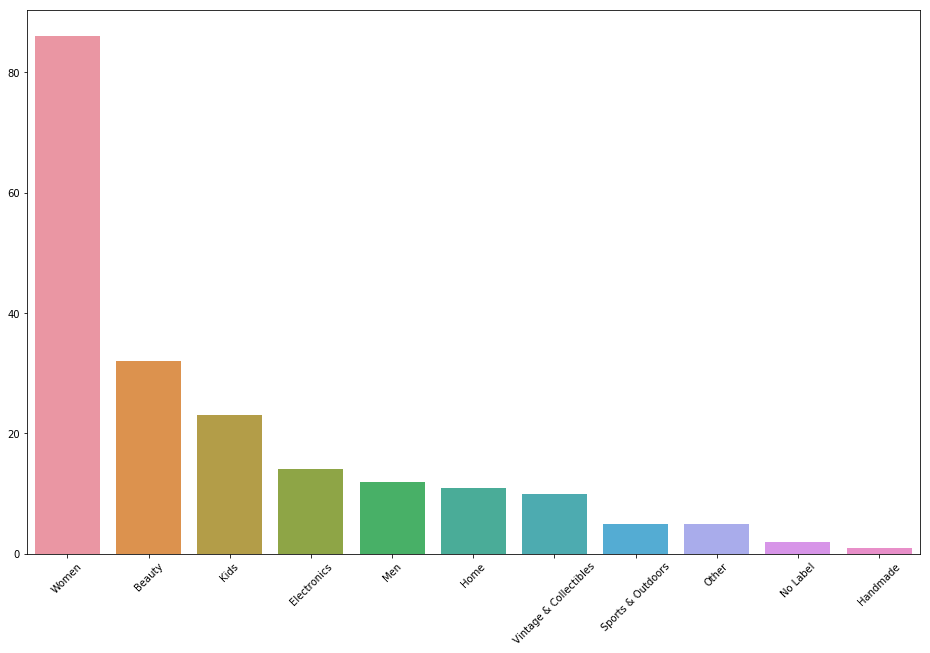

In [13]:
#py.tools.set_credentials_file(username='chengrufeng', api_key='qlKm0juRwDEqEpoHtLiu')#使用账号和key才可以显示图片（plotly）
#使用plotly画柱形图，x是目录名称，y是每个目录中的数据数量。
x = train['general_cat'].value_counts().index.values.astype('str')
y = train['general_cat'].value_counts().values
plt.figure(figsize=[16,10])
sns.barplot(x,y)
plt.xticks(rotation=45)
plt.show()
#pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))]
#trace1 = go.Bar(x=x, y=y, text=pct)
#layout = dict(title= 'Number of Items by Main Category',
#yaxis = dict(title='Count'),
#xaxis = dict(title='Category'))
#fig=dict(data=[trace1], layout=layout)
#pypy.iplot(fig)

In [14]:
def wordCount(text):#统计单词个数函数
    # convert to lower case and strip regex
    try:
         # convert to lower case and strip regex
        text = text.lower()
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
        # tokenize
        # words = nltk.word_tokenize(clean_txt)
        # remove words in stop words
        words = [w for w in txt.split(" ") \
                 if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except:
        return 0

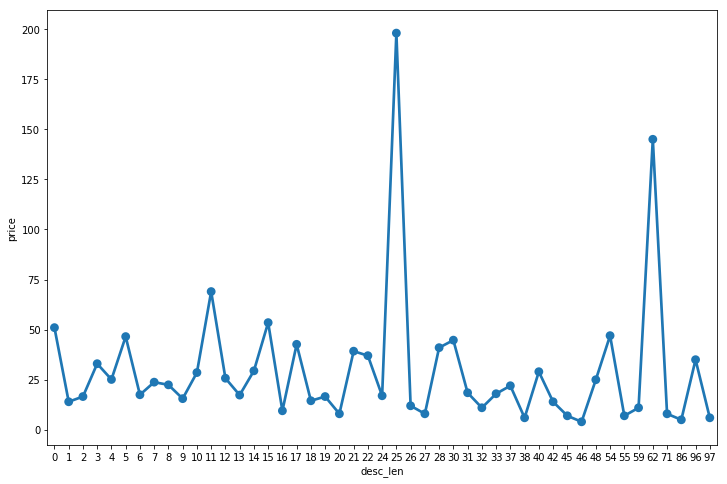

In [16]:
train['desc_len'] = train['item_description'].apply(lambda x: wordCount(x))#统计单词个数，增加一列到desc_len
test['desc_len'] = test['item_description'].apply(lambda x: wordCount(x))
df = train.groupby('desc_len')['price'].mean().reset_index()#按照单词个数分组，统计不同单词个数对应价格的平均值。尝试发现单词个数和价格的关系
plt.figure(figsize=[12,8])
sns.pointplot(x='desc_len',y='price',data=df)#使用seaborn绘图
plt.show()

In [17]:
stop = set(stopwords.words('english'))#使用nltk中的停用词。
def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    分词处理函数，英文的分词不是简单的按照空格分开，如never used实一个词（两个单词）
    """
    try:
        regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')#使用正则表达式，去除符号数字和转义字符等。
        text = regex.sub(" ", text)  # remove punctuation

        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w) >= 3]

        return filtered_tokens

    except TypeError as e:
        print(text, e)

In [18]:
train['tokens'] = train['item_description'].map(tokenize)#调用分词函数，分词结果加入到数据中

In [19]:
#这里是展示部分分词结果
for description, tokens in zip(train['item_description'].head(),
                              train['tokens'].head()):
    print('description:', description)
    print('tokens:', tokens)
    print()

description: No description yet
tokens: ['description', 'yet']

description: This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
tokens: ['keyboard', 'great', 'condition', 'works', 'like', 'came', 'box', 'ports', 'tested', 'work', 'perfectly', 'lights', 'customizable', 'via', 'razer', 'synapse', 'app']

description: Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!
tokens: ['adorable', 'top', 'hint', 'lace', 'key', 'hole', 'back', 'pale', 'pink', 'also', 'available', 'white']

description: New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage
tokens: ['new', 'tags', 'leather', 'horses', 'retail', 'stand', 'foot', 'high', 'sold', 'pair', 'questions', 'please', 

In [20]:
general_cats = train['general_cat'].values
# build dictionary with key=category and values as all the descriptions related.
cat_desc = dict()
for cat in general_cats:
    text = " ".join(train.loc[train['general_cat']==cat, 'item_description'].values)
    cat_desc[cat] = tokenize(text)

In [21]:
# # find the most common words for the top 4 categories(找到每个类别对应的最普遍的100个词)
women100 = nltk.Counter(cat_desc['Women']).most_common(100)
beauty100 = nltk.Counter(cat_desc['Beauty']).most_common(100)
kids100 = nltk.Counter(cat_desc['Kids']).most_common(100)
electronics100 = nltk.Counter(cat_desc['Electronics']).most_common(100)


使用wordcloud产生词云，对不同目录下的高频词进行可视化表示（字越大越普遍）

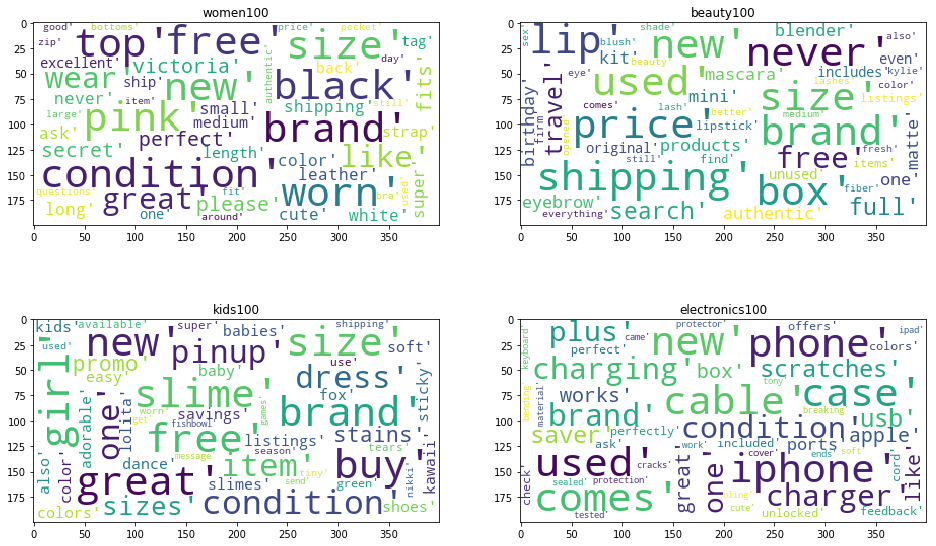

In [24]:
def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          max_words=50, max_font_size=40,
                          random_state=42
                         ).generate(str(tup))
    return wordcloud

plt.figure(figsize=[16,10])
# 以下代码显示图片
plt.subplot(221)
plt.title('women100')
plt.imshow(generate_wordcloud(women100))
plt.subplot(222)
plt.title('beauty100')
plt.imshow(generate_wordcloud(beauty100))
plt.subplot(223)
plt.title('kids100')
plt.imshow(generate_wordcloud(kids100))
plt.subplot(224)
plt.title('electronics100')
plt.imshow(generate_wordcloud(electronics100))
plt.show()

# #使用tfidf模型，实现向量化

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,
                             max_features=180000,
                             tokenizer=tokenize,
                             ngram_range=(1, 2))

all_desc = np.append(train['item_description'].values, test['item_description'].values)#训练和测试数据都要向量化
vz = vectorizer.fit_transform(list(all_desc))
#  create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']
print(tfidf.sort_values(by=['tfidf'], ascending=True).head(10))
print(tfidf.sort_values(by=['tfidf'], ascending=False).head(10))

              tfidf
new        2.170623
size       2.228252
brand      2.722270
condition  2.764830
brand new  2.888063
free       3.047693
shipping   3.047693
worn       3.261267
great      3.285364
never      3.310057
                        tfidf
design               4.601041
come                 4.601041
lip                  4.601041
made                 4.601041
set                  4.601041
gold                 4.601041
shirt                4.601041
size medium          4.601041
navy                 4.601041
excellent condition  4.601041


#这一部分是描述数据转为2维并可视化，使用了svd和tsne.

In [48]:
###这一部分是描述数据转为2维并可视化，使用了svd和tsne.
trn = train.copy()
tst = test.copy()

combined_df = pd.concat([trn, tst])
vz_sample = vectorizer.fit_transform(list(combined_df['item_description']))

from sklearn.decomposition import TruncatedSVD

n_comp=10
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_tfidf = svd.fit_transform(vz_sample)

from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=300)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 402 samples in 0.001s...
[t-SNE] Computed neighbors for 402 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 402 / 402
[t-SNE] Mean sigma: 0.047362
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.270706
[t-SNE] Error after 300 iterations: 0.668583


In [63]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
output_notebook()
#plot_tfidf = figure(plot_width=700, plot_height=600,
#                    title="tf-idf clustering of the item description",
#  tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
#   x_axis_type=None, y_axis_type=None, min_border=1)

tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x', 'y'],index=combined_df.index)
tfidf_df['description'] = combined_df['item_description']
tfidf_df['tokens'] = combined_df['tokens']
tfidf_df['category'] = combined_df['general_cat']

#output_file("scatter.html")

#plot_tfidf.circle(x='x', y='y', source=tfidf_df, alpha=0.7)
plot = figure(tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)
plot.circle(tsne_tfidf[:,0], tsne_tfidf[:,1])
#plot.circle(x='x', y='y',source=tfidf_df,alpha=0.7)

#hover = plot.select(dict(type=HoverTool))
#hover.tooltips={"description": "@description", "tokens": "@tokens", "category":"@category"}


handle = show(plot, notebook_handle=True)

# Update the plot title in the earlier cell
plot.title.text = "tf-idf clustering of the item description"
push_notebook(handle=handle)
##可视化结束
#notebook上展示不太好，可以直接看html文件

Loading BokehJS ...

###这一部分是进行聚类，然后数据可视化

In [64]:
from sklearn.cluster import MiniBatchKMeans

num_clusters = 5 # need to be selected wisely
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters,
                               init='k-means++',
                               n_init=1,
                               init_size=1000, batch_size=1000, verbose=0, max_iter=1000)

kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
# 这个地方应该是要输出所有中心点的值所对应的属性（单词）重要度排序，vectorizer在上面的代码中有变化，不能同时使用。

for i in range(num_clusters):
    print("Cluster %d:" % i)
    aux = ''
    for j in sorted_centroids[i, :10]:
        ## 取出重要度排名前10的属性，每个簇的侧重点是不同的（结果可以看出不同簇的关键词不同）。
        aux += terms[j] + ' | '
    print(aux)
    print()

Cluster 0:
new | authentic | box | size | great | like | brand | used | condition | firm | 

Cluster 1:
size | condition | worn | black | free | new | shipping | description | yet | description yet | 

Cluster 2:
gold | box | beautiful | new | red | make | comes | size | shipping | blue | 

Cluster 3:
brand | brand new | new | used | never | new never | never used | shipping | free | bought | 

Cluster 4:
great | great condition | condition | boys | size | worn | fits | free shipping | small | perfect | 



In [65]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)
# reduce dimension to 2 using tsne
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)
#combined_sample.reset_index(drop=True, inplace=True)
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = kmeans_clusters
combined_df = pd.concat([train, test])
combined_df.index=kmeans_df.index
kmeans_df['description'] = combined_df['item_description']
kmeans_df['category'] = combined_df['general_cat']
# kmeans_df['cluster']=kmeans_df.cluster.astype(str).astype('category')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 402 samples in 0.000s...
[t-SNE] Computed neighbors for 402 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 402 / 402
[t-SNE] Mean sigma: 0.030095
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.970100
[t-SNE] Error after 500 iterations: 0.344745


#使用bokeh.plotting画图

In [69]:
output_notebook()
plot_kmeans = bp.figure(plot_width=700, plot_height=600,
                        title="KMeans clustering of the description",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)
# kmeans_clusters=np.array(kmeans_clusters,dtype=np.str)#转成字符型仍然不行
# tcolor=tuple(kmeans_clusters)
# print(tcolor)

#将类别编号映射成不同的颜色。
dict_color={
    0 : 'red',
    1 : 'green',
    2 : 'blue',
    3 : 'black',
    4 : 'yellow'
}
color_mapped=kmeans_df['cluster'].map(dict_color)
source = ColumnDataSource(data=dict(x=kmeans_df['x'], y=kmeans_df['y'],
                                    color=color_mapped,
                                    description=kmeans_df['description'],
                                    category=kmeans_df['category'],
                                    cluster=kmeans_df['cluster']))#各种数据组合在一起，传递绘图。

plot_kmeans.scatter(x='x', y='y', color='color', source=source)
# plot_kmeans.scatter(kmeans_df,x='x', y='y', color='cluster')
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "category": "@category", "cluster":"@cluster" }
handle = show(plot_kmeans, notebook_handle=True)

# Update the plot title in the earlier cell
plot.title.text = "KMeans clustering of the description"
try:push_notebook(handle=handle)
except: print("这里不知道哪里有错误")

Loading BokehJS ...

不知道哪里有错误


# 使用LDA分析数据，类似于聚类，找到不同主题，并把数据归类到不同主题。

In [70]:
cvectorizer = CountVectorizer(min_df=4,
                              max_features=180000,
                              tokenizer=tokenize,
                              ngram_range=(1,2))
combined_df = pd.concat([train, test])
combined_df.index=np.arange(0,combined_df.index.size)
cvz = cvectorizer.fit_transform(combined_df['item_description'])
lda_model = LatentDirichletAllocation(n_components=3,
                                      learning_method='online',
                                      max_iter=20,
                                      random_state=42)
X_topics = lda_model.fit_transform(cvz)
n_top_words = 10
topic_summaries = []

topic_word = lda_model.components_  # get the topic words
vocab = cvectorizer.get_feature_names()

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))


Topic 0: size | never | black | new | condition | worn | pink | white | cute | used
Topic 1: new | shipping | price | brand | brand new | free | firm | please | description | items
Topic 2: size | great | free | condition | medium | times | box | great condition | home | navy


In [71]:
output_notebook()
# reduce dimension to 2 using tsne

from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)
tsne_lda = tsne_model.fit_transform(X_topics)

unnormalized = np.matrix(X_topics)
doc_topic = unnormalized/unnormalized.sum(axis=1)

lda_keys = []
for i, tweet in enumerate(combined_df['item_description']):
    lda_keys += [doc_topic[i].argmax()]

lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
lda_df['description'] = combined_df['item_description']
lda_df['category'] = combined_df['general_cat']
lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)
#将类别编号映射成不同的颜色。
dict_color={
    0 : 'red',
    1 : 'green',
    2 : 'blue',
    3 : 'black',
    4 : 'yellow'
}
color_mapped=lda_df['topic'].map(dict_color)
source = ColumnDataSource(data=dict(x=lda_df['x'], y=lda_df['y'],
                                    color=color_mapped,
                                    description=lda_df['description'],
                                    topic=lda_df['topic'],
                                    category=lda_df['category']))
#使用bokeh.plotting画图
output_file("text_LDA.html")
plot_kmeans = bp.figure(plot_width=700, plot_height=600,
                        title="LDA of the description",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)
plot_kmeans.scatter(source=source, x='x', y='y', color='color')
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"description":"@description",
                "topic":"@topic", "category":"@category"}
handle = show(plot_kmeans, notebook_handle=True)

# Update the plot title in the earlier cell
plot.title.text = "LDA of the description"
try:push_notebook(handle=handle)
except: print("这里不知道哪里有错误")

Loading BokehJS ...

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 402 samples in 0.001s...
[t-SNE] Computed neighbors for 402 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 402 / 402
[t-SNE] Mean sigma: 0.038739
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.825394
[t-SNE] Error after 500 iterations: 0.193749


这里不知道哪里有错误


差不多这就是kernel中所有的实验结果，目前对数据有了比较好的认识，实验过程也比较熟悉，下一步需要根据分析将数据向量化，然后使用回归算法。